# Code for the figures
This notebook contains scripts for producing figures in the paper and SI.

## Import required libraries 

In [1]:
from scipy.stats import t
from functools import partial
from timeit import default_timer as timer
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from statistics import mean
from scipy.stats import norm
import pandas as pd
import string
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import elfi
from scipy.integrate import quad
%matplotlib inline

## Global variables for plotting

In [2]:
DATA_FOLDER = 'data/'

SIZELINE = 1.0
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE*2, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)

TRUE_MEAN_LABEL = 'True mean, $\mu_t$'
ESTD_MEAN_LABEL = 'Estimated\nmean, $\hat{\mu}$'
TRUE_STD_LABEL = 'True standard\ndeviation, $\sigma_t$'
ESTD_STD_LABEL = 'Estimated standard\ndeviation, $\hat{\sigma}$'
ENCOUNTER_LABEL = 'Target cell encounters'
POA_LABEL = 'Probability of activation'

DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

## Frequently used functions

In [3]:
# update the mean and std
def update(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
	# constants in equtions for variance updating
	varc1 = (alpha-1)/(alpha-0.5)
	varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
	mean = [0]*num_encounter
	std = [0]*num_encounter
	mean[0] = initial_mean
	std[0] = initial_std
	# update mean and std for num_encounter steps
	for nstep in range(1, num_encounter):
		x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
							   varc2*(x-mean[nstep-1])**2)
	return(mean, std)


# Calculate the probability of activation
def POA(alpha, kappa, m, beta, u_target, var_target):
	theta = 0.01
	threshold = t.ppf(1-theta, 2*alpha, m,
					  math.sqrt((kappa+1)*beta/kappa/alpha))
	poa = 1-norm.cdf(threshold, loc=u_target, scale=math.sqrt(var_target))
	return(poa)

# use modified signal to update the mean and variance
def update2(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
	# constants in equtions for variance updating
	varc1 = (alpha-1)/(alpha-0.5)
	varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
	mean = [0]*num_encounter
	std = [0]*num_encounter
	mean[0] = initial_mean
	std[0] = initial_std
	for nstep in range(1, num_encounter):
		x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
		x = mean[nstep-1]+(2/(1 + math.exp(-(x - mean[nstep-1]))) - 1)*2
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
							   varc2*(x-mean[nstep-1])**2)
	return(mean, std)

# numerically calculate the transformed std when signal is modified by x^{'} = m+r*(2/(1+e^{-x})-1),
# x~N(mu,sigma^2) y=x^{'}-m y~(-r,r) assuming m=mu when it converges.
def transformed_std(r,sigma):
	firstmom = quad(lambda y: y*2*r/(math.sqrt(2*math.pi)*sigma*(r**2-y**2))*math.exp(-
					(math.log((r+y)/(r-y)))**2/(2*sigma**2)),-2,2)[0]
	secondmom = quad(lambda y: y**2*2*r/(math.sqrt(2*math.pi)*sigma*(r**2-y**2))*math.exp(-
					(math.log((r+y)/(r-y)))**2/(2*sigma**2)),-2,2)[0]
	return(math.sqrt(secondmom-firstmom**2))

# Figure1. Overview figure

In [17]:
figw = SINGLE_COLUMN/2
figh = figw * 0.5
xmin = -2
xmax = 6
ymin = 0
ymax = 0.42

# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.1
sigma_post = 1
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(1.5, color='k')

plt.savefig('fig1-normal.pdf', format='pdf', dpi=300, transparent=True)
plt.close()


# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.8
sigma_post = 1.2
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(4.0, color='k')

plt.savefig('fig1-aberrant.pdf', format='pdf', dpi=300, transparent=True)
plt.close()

# Figure 2. Immune cells adapt to a static environment

## Part 1. Generation of data for the evolution of mean and standard deviation.

In [70]:
# Figure 2 data generation
alphas = [5, 10, 20]
kappas = [10, 20, 40]
m_env = 0
var_env = 4
num_encounter = 200
df = pd.DataFrame({'Initial mean': [],
                   'Initial std': [],
                   'True mean': [],
                   'True std': [],
                   'alpha': [],
                   'kappa': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': []
                   })
datatype_dict = {'Initial mean': float,
                 'Initial std': float,
                 'True mean': float,
                 'True std': float,
                 'alpha': int,
                 'kappa': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float
                 }
df = df.astype(datatype_dict)

for alpha, kappa in zip(alphas, kappas):
    # case 1. initial different mean and same var ------------------------------------
    initial_means = np.arange(-10, 11, 2)
    initial_std = 1
    num_means = len(initial_means)
    for i_case in range(num_means):
        initial_mean = initial_means[i_case]
        mean, std = update(initial_mean, initial_std, alpha,
                           kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [math.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    # case 2. initial same mean and different var ------------------------------------
    initial_mean = 0
    initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
    num_stds = len(initial_stds)
    for i_case in range(num_means, num_means+num_stds):
        initial_std = initial_stds[i_case-num_means]
        mean, std = update(initial_mean, initial_std, alpha,
                           kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [math.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    df.to_csv('estimated_mean_std.csv.gz', index=None,
              header=True, compression='gzip')

print('Fig 2 data done')

Fig 2 data done


## Part 2. Plotting

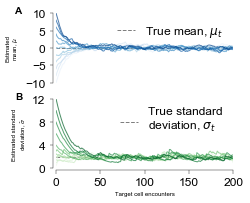

In [71]:
# Figure 2 plottting

alpha = 5
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
#initial_stds = [2]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sestimated_mean_std.csv.gz' %
				   DATA_FOLDER, compression='gzip')

# Plotting -----------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.93, string.ascii_uppercase[0].upper(), size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.485, string.ascii_uppercase[1].upper(), size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

# Case 1 different means and same variance ---------------
mu_c = sns.color_palette('Blues', n_colors=num_means)
for j_mu in range(num_means):
	mean = data.loc[(data['alpha'] == alpha) 
					& (data['Initial mean'] == initial_means[j_mu]) 
					& (data['Initial std'] == initial_std)]['Mean']
	encouner = range(len(mean))
	ax1.plot(encouner, mean, alpha=0.7, c=mu_c[j_mu])


# Case 2 initial same mu and different var ---------------
std_c = sns.color_palette('Greens', n_colors=num_stds)
for j_std in range(num_stds):
	std = data.loc[(data['alpha'] == alpha) 
				   & (data['Initial mean'] == initial_mean) 
				   & (data['Initial std'] == initial_stds[j_std])]['Std']
	encounter = range(len(std))
	ax2.plot(encounter, std, alpha=0.7, c=std_c[j_std])

plt.savefig('fig2-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

##  Generation of data for evolution of estimated mean, standard deviation and probaility of activation for figure 3 & SI figure 2.

In [14]:
# Figure 3/SI2 data generation
# variables
num_cell = 500
alpha = 10
kappa = 20
m_env1 = 0 # mean and variance of environments
var_env1 = 1
m_env2 = 5  
var_env2 = 4
num1env = 50 # encounter numbers in environments
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

df = pd.DataFrame({'alpha': [],
                   'kappa': [],
                   'True mean': [],
                   'True std': [],
                   'Cell No': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': [],
                   'Beta': [],
                   'Poa': []
                   })
datatype_dict = {'alpha': int,
                 'kappa': int,
                 'True mean': float,
                 'True std': float,
                 'Cell No': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float,
                 'Beta': float,
                 'Poa': float
                 }
df = df.astype(datatype_dict)

# loop over num_cell
for i_cell in range(num_cell):
    # healthy environment
    mean, std = update(m_env1, math.sqrt(var_env1), alpha,
                       kappa, num1env, m_env1, var_env1)
    # unhealthy environment
    a, b = update(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
    mean += a
    std += b
    # healthy environment
    a, b = update(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
    mean += a
    std += b
    # calculate beta and poa
    beta = [item**2*(alpha-1) for item in std]
    poa = [POA(alpha, kappa, item1, item2, m_env2, var_env2)
           for item1, item2 in zip(mean, beta)]

    # data saving ----------------------------------------------------
    df2 = pd.DataFrame({'alpha': [alpha]*total_num,
                        'kappa': [kappa]*total_num,
                        'True mean': [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env,
                        'True std': [math.sqrt(var_env1)]*num1env
                                    + [math.sqrt(var_env2)]*num2env
                                    + [math.sqrt(var_env1)]*num3env,
                        'Cell No': [i_cell]*total_num,
                        'Encounters': np.arange(total_num),
                        'Mean': mean,
                        'Std': std,
                        'Beta': beta,
                        'Poa': poa
                        })
    df = pd.concat([df, df2])
print(df.head())
df.to_csv('MultiEnvs_MultiCells_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('MultiEnvs_MultiCells_mean_std_beta_poa data done')

   alpha  kappa  True mean  True std  Cell No  Encounters      Mean       Std  \
0     10     20        0.0       1.0        0           0  0.000000  1.000000   
1     10     20        0.0       1.0        0           1 -0.020388  0.978037   
2     10     20        0.0       1.0        0           2  0.003138  0.958357   
3     10     20        0.0       1.0        0           3  0.005573  0.932866   
4     10     20        0.0       1.0        0           4  0.027743  0.913948   

       Beta       Poa  
0  9.000000  0.898182  
1  8.609014  0.904638  
2  8.266025  0.906726  
3  7.832150  0.911647  
4  7.517716  0.913579  
MultiEnvs_MultiCells_mean_std_beta_poa data done


# Figure 3. Immune cells adapt to changing environments, mimicking experimentally observed development of hyposensitivity and recovery

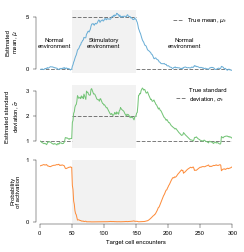

In [20]:
# Fig 3. plot

alpha = 10
kappa = 20
varc1 = (alpha-1)/(alpha-0.5) # constants frequently used
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0 # mean and variance of environments
var_env1 = 1
m_env2 = 5  
var_env2 = 4
num1env = 50 # encounter numbers
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.26])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.26])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.26])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2, 3])
ax2.set_yticklabels([1, 2, 3])
ax3.set_yticks([0, 1])

ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env1), xmin=0, xmax=num1env,
           label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env2), xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env1), xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax1.spines['left'].set_bounds(0, 5)
ax2.spines['left'].set_bounds(1, 3)
ax3.spines['left'].set_bounds(0, 1)

ax3.set_ylim(-0.01, 1)

mu_c = sns.color_palette('Blues', n_colors=1)
std_c = sns.color_palette('Greens', n_colors=1)
poa_c = sns.color_palette('Oranges', n_colors=1)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)
ax1.plot(data.loc[data['Cell No'] == 0]['Mean'], c=mu_c[0])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data.loc[data['Cell No'] == 0]['Std'], c=std_c[0])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data.loc[data['Cell No'] == 0]['Poa'], c=poa_c[0])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')

ax1.text(23, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(100, 2.5, 'Stimulatory\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(225, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)

plt.savefig('fig3-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 4. Steady state distribution of immune cell adaptation and responsiveness due to finite memory

## Part 1. Solve the Fokker Planck Equation (See FKE.py which generates 'Fokker_planck_solution.csv.gz')

## Part 2. Calculate the probability of activation

In [6]:
# Fig 4 calculate poa at (m,\beta) points
u2 = 2  # signal mean and std
sigma2 = 1  
theta = 0.01
alpha = 10
kappa = 20
c1 = (alpha-1)/(alpha-0.5) # constant in betanew = c1*beta + c2*(x-mu)**2
c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
alpha = 10
kappa = 20
mean_antigen = 4.5  # antigen N(4.5,1) when calculating POA
var_antigen = 1

# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

m = [0]*(NX*NY)
beta = [0]*(NX*NY)
poa = [0]*(NX*NY)
for i in range(NX):
    for j in range(NY):
        m[i*NY+j] = xmin+i*dx
        beta[i*NY+j] = ymin+j*dy
        poa[i*NY+j] = POA(alpha, kappa, m[i*NY+j],
                          beta[i*NY+j], mean_antigen, var_antigen)
df = pd.DataFrame()
df['alpha'] = [alpha]*(NX*NY)
df['kappa'] = [kappa]*(NX*NY)
df['Antigen mean'] = [mean_antigen]*(NX*NY)
df['Antigen var'] = [var_antigen]*(NX*NY)
df['M'] = m
df['Beta'] = beta
df['Poa'] = poa
df.to_csv('poa_matrix.csv.gz', index=None, header=True, compression='gzip')
print('Fig 4 poa matrix done')

Fig 4 poa matrix done


## Part 3. Plotting

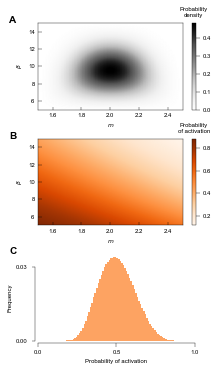

In [10]:
# Fig 4 3/3
# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

# load data
dataw = pd.read_csv('%sFokker_planck_solution.csv.gz' %
                    (DATA_FOLDER), compression='gzip')
col = dataw.columns[-1]
w = dataw[col]
w = np.array(w).reshape((NX, NY))
data = pd.read_csv('%spoa_matrix.csv.gz' % (DATA_FOLDER), compression='gzip')
poa = np.array(data['Poa']).reshape((NX, NY))

# plotting ---------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
h = 0.24
s = 0.08
ax1 = fig.add_axes([0.15, 0.95 - h, 0.75, h])
ax2 = fig.add_axes([0.15, 0.95 - 2*h - s, 0.75, h])
ax3 = fig.add_axes([0.15, 0.95 - 3*h - 2*s, 0.65, h])
fig.text(
    0.03, 0.95, string.ascii_uppercase[0].upper(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - (h+s), string.ascii_uppercase[1].upper(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - 2*(h+s), string.ascii_uppercase[2].upper(), size=SUBLABEL_SIZE, weight='bold')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$m$')
ax2.set_ylabel(r'$\beta$')

ax3.set_xlabel(POA_LABEL)
ax3.set_ylabel('Frequency')
ax3.set_xlim([0, 1])
ax3.set_ylim([-0.0002, 0.035])
ax3.set_yticks([0, 0.03])
ax3.spines['left'].set_bounds(0, 0.03)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
X = xmin+dx*np.arange(NX)
Y = ymin+dy*np.arange(NY)

colorinterpolation = 50  # Set colour interpolation and colour map
pos1 = ax1.pcolormesh(X, Y, w.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Greys'))
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('Probability\ndensity', fontsize=LABEL_SIZE)
cbar1.set_ticks(np.arange(0, 0.9, step=0.1))

pos2 = ax2.pcolormesh(X, Y, poa.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Oranges'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('Probability\nof activation', fontsize=LABEL_SIZE)
cbar2.set_ticks(np.arange(0, 1, step=0.2))

poa_c = sns.color_palette('Oranges', n_colors=1)

# bins for poa histgram
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
xbin = []
y3 = []
for ibin in range(int(1.0/binstep)):
    xbin.append((ibin+0.5)*binstep)
    y3.append(0)
for ix in range(NX):
    for iy in range(NY):
        ibin = 0
        while ibin*binstep < poa[ix, iy]:
            ibin += 1
        y3[ibin] += w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
ax3.bar(xbin, height=y3plot, width=binstep, align='center', alpha=0.8, facecolor=poa_c[0])
ax3.set_xticks([0, 0.5, 1])

plt.savefig('fig4-heterogeneity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 5. Immune cells responses are diverse, but follow predictable trends de- pending on the level of stimulation received from target cells. 

## Part 1. Evolution of probability distibution of (mu, beta) in different memory and calculate the corresponding POA

In [71]:
def update_mubeta(initial_mean, initial_beta, alpha, kappa, num_encounter, m_env, var_env):
    c1 = (alpha-1)/(alpha-0.5) # constant in betanew = c1*beta + c2*(x-mu)**2
    c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
    mean_old = initial_mean
    beta_old = initial_beta
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        mean_new = (kappa*mean_old+x)/(kappa+1)
        beta_new = c1*beta_old+c2*(x-mean_old)**2
        mean_old, beta_old = mean_new, beta_new
    return(mean_new, beta_new)


# variables
num_cells = 100000  
num_encounter = 1000
m_env = 2
var_env = 1
u2s = [6, 5, 4, 3]
alpha_vals = [5, 10, 20, 50]
var2 = 1
num_u2s = len(u2s)

df = pd.DataFrame({'alpha': [],
                   'Cell No': [],
                   'Antigen mean': [],
                   'Antigen std': [],
                   'M': [],
                   'Beta': [],
                   'Poa': []
                   })
datatype_dict = {'alpha': int,
                 'Cell No': int,
                 'Antigen mean': float,
                 'Antigen std': float,
                 'M': float,
                 'Beta': float,
                 'Poa': float
                 }
df = df.astype(datatype_dict)

# initial distribution form and number of NK cells
init_m = [0]*num_cells
init_beta = [0]*num_cells
for i in range(num_cells):
    init_m[i] = random.random()*5  # [0,5)
    init_beta[i] = random.random()*40  # [0,40)

# loop to get m beta distribution after num_encounter steps
for u2 in u2s:
    print('target mean', u2)
    for alpha in alpha_vals:
        print('alpha', alpha)
        print(timer())
        kappa = 2*alpha
        m = np.zeros(num_cells)
        beta = np.zeros(num_cells)
        poa = np.zeros(num_cells)
        for i_cell in range(num_cells):
            if i_cell % 10000 == 0:
                print(i_cell, timer())
            m[i_cell], beta[i_cell] = update_mubeta(init_m[i_cell], init_beta[i_cell],
                                                    alpha, kappa, num_encounter, m_env, var_env)
            poa[i_cell] = POA(alpha, kappa, m[i_cell], beta[i_cell], u2, var2)
        df2 = pd.DataFrame({'alpha': [alpha]*num_cells,
                            'Cell No': np.arange(num_cells),
                            'Antigen mean': [u2]*num_cells,
                            'Antigen std': [var2]*num_cells,
                            'M': m,
                            'Beta': beta,
                            'Poa': poa
                            })
        df = pd.concat([df, df2])
df.to_csv('diff_memory_population.csv.gz',
          index=None, header=True, compression='gzip')
print('update mu beta done')

target mean 6
alpha 5
22363.069209552
0 22363.069572142
10000 22374.172634891
20000 22385.141674321
30000 22396.176357874
40000 22407.126599577
50000 22418.166396487
60000 22429.04159289
70000 22439.928496489
80000 22450.894949832
90000 22461.805445731
alpha 10
22472.725368268
0 22472.725836343
10000 22483.61515215
20000 22494.523474735
30000 22505.61715896
40000 22516.455070558
50000 22530.006898298
60000 22541.220348301
70000 22552.736579878
80000 22563.846468046
90000 22575.632115753
alpha 20
22586.691595028
0 22586.69202375
10000 22597.67059859
20000 22608.676242667
30000 22619.693298625
40000 22630.733390105
50000 22641.686559119
60000 22653.608384139
70000 22664.777650205
80000 22675.751544075
90000 22686.734981571
alpha 50
22697.766673765
0 22697.767076144
10000 22708.747585592
20000 22719.73956204
30000 22730.720909513
40000 22741.732557938
50000 22752.837207813
60000 22763.830387378
70000 22774.93591103
80000 22785.969668558
90000 22797.259691511
target mean 5
alpha 5
22808.20

## Part 2. Plotting

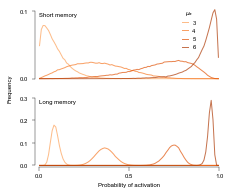

In [29]:
# Fig 5 different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('%sdiff_memory_population.csv.gz' %
                   DATA_FOLDER, compression='gzip')

alpha_vals = [5, 10, 20, 50]
num_cells = 100000

# bins and bar middle points
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
x = []
for ibin in range(int(1.0/binstep)):
    x.append((ibin+0.5)*binstep)

# figure size
w = 0.75
h = 0.35

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(0.03, 0.55, 'Frequency', rotation='vertical',
         ha='center', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.93, 'Short memory',
         ha='left', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.83-h, 'Long memory',
         ha='left', va='center', fontsize=LABEL_SIZE)

ax1 = fig.add_axes([0.15, 0.95-1*h, w, h])
ax2 = fig.add_axes([0.15, 0.85-2*h, w, h])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax1.set_ylim([0, 0.10])
ax2.set_ylim([0, 0.30])
ax1.set_yticks([0, 0.1])
ax2.set_yticks([0, 0.1, 0.2, 0.3])

ax1.set_xticks([])
ax2.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False, labelbottom=False)
ax2.set_xlabel(POA_LABEL)

poa_c = sns.color_palette('Oranges', n_colors=6)

u_vals = [3, 4, 5, 6]

for i in range(len(u_vals)):
    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 5)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax1.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2], label=u_vals[i])

    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 50)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax2.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2])

ax1.legend(title=r'$\mu_a$', loc='center', bbox_to_anchor=(
    0.83, 0.73), borderaxespad=0, ncol=1, handlelength=1, frameon=False)


plt.savefig('fig5-heterogeneity-response.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 6 Serial killing

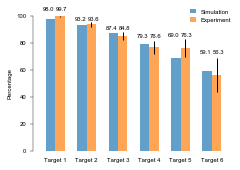

In [75]:
def initial_parameters(alpha,N):
	# update m=300 steps, healthy signal N(0,1)
	n_updates=300
	kappa = 2*alpha
	ms=np.zeros(N)
	betas=np.ones(N)*alpha
	for j in range(n_updates):
		xs = np.random.randn(N)
		ms_new = (xs+kappa*ms)/(kappa+1)
		betas_new = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms=ms_new
		betas = betas_new
	return(ms,betas)

def serial_kill(alpha, mu_t, sigma_t):
	N=1000 # number of cells
	kappa = 2*alpha
	m,beta = initial_parameters(alpha,N)
	p = np.zeros(6)
	for i_encounter in range(6):
		threshold = t.ppf(0.99, 2*alpha, m, np.sqrt((kappa+1)*beta/kappa/alpha))
		x_rand = np.random.normal(mu_t,sigma_t,N)
		k = x_rand>threshold
		pk=0
		for j in range(N):
			if k[j]==True :
				pk += 1
		pk = pk/N
		p[i_encounter] = pk
		mnew = (kappa*m+x_rand)/(kappa+1)
		betanew = (alpha-1)/(alpha-0.5)*(beta+0.5*kappa/(kappa+1)*(m-x_rand)**2)
		m = mnew
		beta = betanew
	return(p)
y_exp = np.array([[0.997, 0.936, 0.848, 0.766, 0.763, 0.563]])
n_exp = np.array([347,250,151,77,38,16])
y_exp_array = np.array([0.997, 0.936, 0.848, 0.766, 0.763, 0.563])
y_exp_std = np.sqrt(y_exp_array*(1-y_exp_array))
y_exp_bar = y_exp_std/np.sqrt(n_exp)

alpha,mu,sigma = 24.82, 6.85, 2.18
y = serial_kill(alpha,mu,sigma)
# convert to percentage
y_percent = y*100
y_exp_percent = y_exp_array*100 
y_exp_bar_percent = y_exp_bar*100 

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax = fig.add_axes([0.15, 0.15, 0.8, 0.7])
ax.spines['left'].set_position(('axes', -0.02))
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

bar_width = 0.3
d_bar = 0.15
x = np.array([1,2,3,4,5,6])
ax.bar(x-d_bar,y_percent, width=bar_width, label='Simulation', alpha=0.7)
ax.bar(x+d_bar,y_exp_percent,yerr=y_exp_bar_percent,width=bar_width, label = 'Experiment', alpha=0.7)
y_label = np.array([105,98,91,85,86,73]) # height of text
for index, value in enumerate(y_percent):
	ax.text(index+1-0.21, y_label[index], '%.1f'%value, ha='center', va='center', fontsize=LABEL_SIZE)
for index, value in enumerate(y_exp_percent):
	ax.text(index+1+0.21, y_label[index], '%.1f'%value, ha='center', va='center', fontsize=LABEL_SIZE)
ax.legend(loc='center',bbox_to_anchor=(0.85, 0.75, 0.1, 0.5),handlelength=1, frameon=False)
ax.set_ylabel('Percentage')
ax.set_xticks(x)
ax.tick_params(axis='x',bottom=False,labelbottom=True)
ax.set_xticklabels(['Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6'])

ax.set_ylim(0,100)
#ax.text(0.5, 1.1, r'$\alpha$=%.2f, $\mu$=%.2f, $\sigma$=%.2f'%(alpha,mu,sigma),
#         horizontalalignment='center',
#        fontsize=LABEL_SIZE,
#         transform = ax.transAxes)
plt.show()
fig.savefig('fig6-serialkill.pdf', dpi=300)

# SI Figure 1. Immune cells adapt to a static environment under different memory

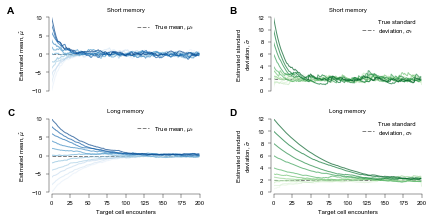

In [6]:
# SI Fig 1  different memory
# Compare alpha = 5 vs 20

alphas = [5, 20]
kappas = [10, 40]
alpha_shortmem = 5
kappa_shortmem = 10
alpha_longmem = 20
kappa_longmem = 40
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

if __name__ == '__main__':
    fig = plt.figure(figsize=(DOUBLE_COLUMN, 3))
    plt.rc('font', size=LABEL_SIZE, family=FAMILY)
    ax1 = fig.add_axes([0.15, 0.59, 0.3, 0.34])
    ax2 = fig.add_axes([0.15, 0.12, 0.3, 0.34])
    ax3 = fig.add_axes([0.60, 0.59, 0.3, 0.34])
    ax4 = fig.add_axes([0.60, 0.12, 0.3, 0.34])
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax1.spines['left'].set_position(('axes', -0.02))
    ax3.spines['left'].set_position(('axes', -0.02))
    ax2.spines['bottom'].set_position(('axes', -0.02))
    ax2.spines['left'].set_position(('axes', -0.02))
    ax4.spines['bottom'].set_position(('axes', -0.02))
    ax4.spines['left'].set_position(('axes', -0.02))
    ax1.set_xlim([0, num_encounter])
    ax1.set_ylim([-10, 10])
    ax2.set_xlim([0, num_encounter])
    ax2.set_ylim([-10, 10])
    ax3.set_xlim([0, num_encounter])
    ax3.set_ylim([0, 12])
    ax4.set_xlim([0, num_encounter])
    ax4.set_ylim([0, 12])

    ax1.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax1.text(-0.3, 1.05, string.ascii_uppercase[0].upper(),
             transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax1.set_title(r'Short memory', fontsize=LABEL_SIZE)

    ax2.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax2.legend(loc='upper right', frameon=False)
    ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax2.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax2.text(-0.3, 1.05, string.ascii_uppercase[2].upper(),
             transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax2.set_title(r'Long memory', fontsize=LABEL_SIZE)

    ax3.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax3.legend(loc='upper right', frameon=False)
    ax3.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax3.text(-0.3, 1.05, string.ascii_uppercase[1].upper(),
             transform=ax3.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax3.set_title(r'Short memory', fontsize=LABEL_SIZE)

    ax4.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax4.legend(loc='upper right', frameon=False)
    ax4.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax4.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax4.text(-0.3, 1.05, string.ascii_uppercase[3].upper(),
             transform=ax4.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax4.set_title(r'Long memory', fontsize=LABEL_SIZE)

    # different initial mean and same var ------------------------------------
    
    mu_c = sns.color_palette('Blues', n_colors=num_means)
    std_c = sns.color_palette('Greens', n_colors=num_stds)
    
    data = pd.read_csv('%sestimated_mean_std.csv.gz' %
                       DATA_FOLDER, compression='gzip')
    for j_mu in range(num_means):
        mean_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                 (data['kappa'] == kappa_shortmem) &
                                 (data['Initial mean'] == initial_means[j_mu]) &
                                 (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_shortmem))
        ax1.plot(encouner, mean_shortmem, alpha = 0.7, c = mu_c[j_mu])
        mean_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                                (data['kappa'] == kappa_longmem) &
                                (data['Initial mean'] == initial_means[j_mu]) &
                                (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_longmem))
        ax2.plot(encouner, mean_longmem, alpha = 0.7, c = mu_c[j_mu])
	# different initial std and same mean ------------------------------------
    for j_std in range(num_stds):
        std_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                (data['kappa'] == kappa_shortmem) &
                                (data['Initial mean'] == initial_mean) &
                                (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_shortmem))
        ax3.plot(encounter, std_shortmem, alpha = 0.7, c = std_c[j_std])
        std_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                               (data['kappa'] == kappa_longmem) &
                               (data['Initial mean'] == initial_mean) &
                               (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_longmem))
        ax4.plot(encounter, std_longmem, alpha = 0.7, c = std_c[j_std])
    plt.savefig('figs1-adaptation-memory.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# SI Figure 2. Finite memory of past interactions with target cells results in heterogeneous immune cell behaviors

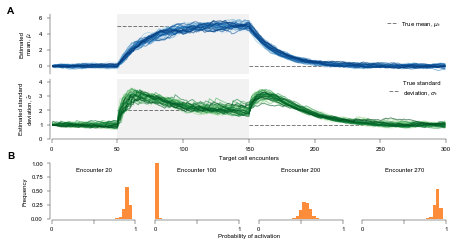

In [7]:
# FigS2

num_cell = 500
num_lines = 50
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv(
    '%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' % (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(
    0.05, 0.95, string.ascii_uppercase[0].upper(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.05, 0.35, string.ascii_uppercase[1].upper(), size=SUBLABEL_SIZE, weight='bold')

ax1 = fig.add_axes([0.14, 0.7, 0.8, 0.25])
ax2 = fig.add_axes([0.14, 0.43, 0.8, 0.25])
ax3 = fig.add_axes([0.14, 0.1, 0.17, 0.23])
ax4 = fig.add_axes([0.35, 0.1, 0.17, 0.23])
ax5 = fig.add_axes([0.56, 0.1, 0.17, 0.23])
ax6 = fig.add_axes([0.77, 0.1, 0.17, 0.23])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.005))
ax1.spines['bottom'].set_position(('axes', -0.005))
ax2.spines['left'].set_position(('axes', -0.005))
ax2.spines['bottom'].set_position(('axes', -0.005))
ax1.set_ylim(-1, 6.5)
ax2.set_ylim(0, 4.2)
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax1.set_xticks([])

ax1.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax2.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax1.hlines(0, xmin=-10, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(5, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(0, xmin=num1env+num2env, xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=1, xmin=-10, xmax=num1env, label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=1, xmin=num1env+num2env, xmax=num1env +
           num2env+num3env, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

mu_c = sns.color_palette('Blues', n_colors=num_lines)
std_c = sns.color_palette('Greens', n_colors=num_lines)
for i_cell in range(num_lines):
    ax1.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Mean'], alpha=0.6, c=mu_c[i_cell])
ax1.set_ylabel(ESTD_MEAN_LABEL)

for i_cell in range(num_lines):
    ax2.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Std'], alpha=0.6, c=std_c[i_cell])
ax2.set_ylabel(ESTD_STD_LABEL)

ax2.set_xlabel(ENCOUNTER_LABEL)

ax3.set_xticks(np.arange(0, 1.01, step=0.5))
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax5.set_xticks(np.arange(0, 1.01, step=0.5))
ax6.set_xticks(np.arange(0, 1.01, step=0.5))
ax3.set_xticklabels(['0', '', '1'])
ax4.set_xticklabels(['0', '', '1'])
ax5.set_xticklabels(['0', '', '1'])
ax6.set_xticklabels(['0', '', '1'])
ax3.set_ylim([0, 1])
ax4.set_ylim([0, 1])
ax5.set_ylim([0, 1])
ax6.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
ax5.set_xlim([0, 1])
ax6.set_xlim([0, 1])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))
ax5.spines['bottom'].set_position(('axes', -0.02))
ax6.spines['bottom'].set_position(('axes', -0.02))

ax3.set_ylabel('Frequency')
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

binstep = 0.04
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

xbins = []
for ibin in range(int(1.0/binstep)):
    xbins.append(binstep*ibin)

# -----------------------------

step_vals = [20, 100, 200, 270]
axes = [ax3, ax4, ax5, ax6]

poa_c = sns.color_palette('Oranges', n_colors=1)[0]

for nstep, ax in zip(step_vals, axes):
    pointpoas = data.loc[data['Encounters'] == nstep]['Poa']
    statist = np.histogram(pointpoas, bins)[0]/num_cell
    ax.bar(xbins, height=statist, width=binstep, align='edge', fc=poa_c)
    ax.text(0.5, 0.85, 'Encounter %d' %
            nstep, ha='center', fontsize=LABEL_SIZE, color='k')

# ----------------------
fig.text(0.54, 0.02, POA_LABEL, ha='center')
plt.savefig('figs2-adaptation-dynamic-population.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 3

## Part 1 Generation of data for the evolution of mean and standard deviation using transformed signal.

In [33]:
# variables
alpha = 10
kappa = 20
m_env = 0
var_env = 4
num_encounter = 200

df = pd.DataFrame({'Initial mean': [],
                   'Initial std': [],
                   'True mean': [],
                   'True std': [],
                   'alpha': [],
                   'kappa': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': []
                   })
datatype_dict = {'Initial mean': float,
                 'Initial std': float,
                 'True mean': float,
                 'True std': float,
                 'alpha': int,
                 'kappa': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float
                 }
df = df.astype(datatype_dict)

# case 1. initial different mean and same var ------------------------------------
initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)
for i_case in range(num_means):
    initial_mean = initial_means[i_case]
    mean, std = update2(initial_mean, initial_std, alpha,
                        kappa, num_encounter, m_env, var_env)
    num_rows = len(mean)
    df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                        'Initial std': [initial_std]*num_rows,
                        'True mean': [m_env]*num_rows,
                        'True std': [math.sqrt(var_env)]*num_rows,
                        'alpha': [alpha]*num_rows,
                        'kappa': [kappa]*num_rows,
                        'Encounters': np.arange(num_rows),
                        'Mean': mean,
                        'Std': std
                        })
    df = pd.concat([df, df2])

# case 2. initial same mean and different var ------------------------------------
initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)
for i_case in range(num_means, num_means+num_stds):
    initial_std = initial_stds[i_case-num_means]
    mean, std = update2(initial_mean, initial_std, alpha,
                        kappa, num_encounter, m_env, var_env)
    num_rows = len(mean)
    df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                        'Initial std': [initial_std]*num_rows,
                        'True mean': [m_env]*num_rows,
                        'True std': [math.sqrt(var_env)]*num_rows,
                        'alpha': [alpha]*num_rows,
                        'kappa': [kappa]*num_rows,
                        'Encounters': np.arange(num_rows),
                        'Mean': mean,
                        'Std': std
                        })
    df = pd.concat([df, df2])

df.to_csv('SI3_estimated_mean_std_alpha%d.csv.gz' %
          alpha, index=None, header=True, compression='gzip')
print('Fig SI 3 data done')

Fig SI 3 data done


## Part 2. Plotting SI Figure 3

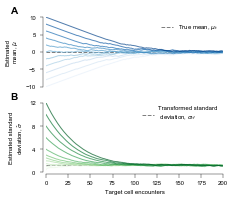

In [8]:
alpha = 10  
kappa = 20 
m_env = 0
var_env = 4
std_tf = transformed_std(2,math.sqrt(var_env)) # calculater transformed std
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sSI3_estimated_mean_std_alpha%d.csv.gz' %
                   (DATA_FOLDER, 10), compression='gzip')

# Plotting -----------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
ax1.text(-0.2, 1.05, string.ascii_uppercase[0].upper(),
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
ax2.text(-0.2, 1.05, string.ascii_uppercase[1].upper(),
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(
    std_tf, label='Transformed standard\n deviation, $\sigma_{tf}$', **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

mu_c = sns.color_palette('Blues', n_colors=num_means)
std_c = sns.color_palette('Greens', n_colors=num_stds)

# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
    mean = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] == initial_means[j_mu]) 
                    & (data['Initial std'] == initial_std)]['Mean']
    encouner = range(len(mean))
    ax1.plot(encouner, mean, alpha = 0.7, c = mu_c[j_mu])

# Case 2 initial same mu and different var ---------------
for j_std in range(num_stds):
    std = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] == initial_mean) 
                   & (data['Initial std'] == initial_stds[j_std])]['Std']
    encounter = range(len(std))
    ax2.plot(encounter, std, alpha = 0.7, c = std_c[j_std])

plt.savefig('figs3-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 4

## Part 1. Generation of data for evolution of estimated mean, standard deviation and probaility of activation using transformed signal

In [25]:
alpha = 10
kappa = 20
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  
var_env2 = 4
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

mean = [0]*total_num
std = [0]*total_num
poa = [0]*total_num
beta = [0]*total_num
mean[0] = m_env1
std[0] = math.sqrt(var_env1)
beta[0] = std[0]**2*(alpha-1)
poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))

# healthy environment
mean, std = update2(m_env1, math.sqrt(var_env1), alpha,
                    kappa, num1env, m_env1, var_env1)

# unhealthy environment
a, b = update2(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
mean += a
std += b

# healthy environment
a, b = update2(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
mean += a
std += b

# calculate the poa
for nstep in range(total_num):
    beta[nstep] = std[nstep]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep],
                     beta[nstep], m_env2, var_env2)

# data saving ----------------------------------------------------
df = pd.DataFrame()
df['alpha'] = [alpha]*total_num
df['kappa'] = [kappa]*total_num
df['True mean'] = [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env
df['True std'] = [math.sqrt(var_env1)]*num1env + \
    [math.sqrt(var_env2)]*num2env+[math.sqrt(var_env1)]*num3env
df['Mean'] = mean
df['Std'] = std
df['Beta'] = beta
df['Poa'] = poa
df.to_csv('SI4_MultiEnvs_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('Fig SI 4 data done')

Fig SI 4 data done


## Part 2 Plotting SI Figure 4

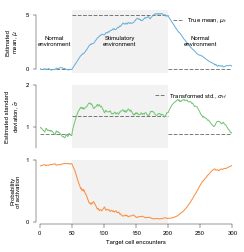

In [56]:
# SI Fig 4. plot

alpha = 10
kappa = 20
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
std_1_tf = transformed_std(2,math.sqrt(var_env1))  # calculater transformed std
m_env2 = 5 
var_env2 = 4
std_2_tf = transformed_std(2,math.sqrt(var_env2))
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sSI4_MultiEnvs_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.26])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.26])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.26])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax3.set_xlim(0, 300)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2])
ax2.set_yticklabels([1, 2])
ax2.set_ylim(0.5, 2)
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax2.hlines(y=std_1_tf, xmin=0, xmax=num1env,
           label='Transformed std., $\sigma_{tf}$', **DASH_STYLE)
ax2.hlines(y=std_2_tf, xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=std_1_tf, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax1.spines['left'].set_bounds(0, 5)
ax2.spines['left'].set_bounds(0.5, 2)
ax3.set_ylim(-0.01, 1)
ax3.spines['left'].set_bounds(0, 1)

ax3.set_ylim(-0.01, 1)
ax1.text(23, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(125, 2.5, 'Stimulatory\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(250, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)

mu_c = sns.color_palette('Blues', n_colors=1)
std_c = sns.color_palette('Greens', n_colors=1)
poa_c = sns.color_palette('Oranges', n_colors=1)

ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)
ax1.plot(data['Mean'], c = mu_c[0])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data['Std'], c = std_c[0])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data['Poa'], c = poa_c[0])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')
plt.savefig('figs4-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 5


In [48]:
# Figure 2 data generation
alphas = [5, 10, 20]
kappas = [10, 20, 40]
m_env = 0
var_env = 4
num_encounter = 1000
df = pd.DataFrame({'Initial mean': [],
                   'Initial std': [],
                   'True mean': [],
                   'True std': [],
                   'alpha': [],
                   'kappa': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': []
                   })
datatype_dict = {'Initial mean': float,
                 'Initial std': float,
                 'True mean': float,
                 'True std': float,
                 'alpha': int,
                 'kappa': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float
                 }
df = df.astype(datatype_dict)

for alpha, kappa in zip(alphas, kappas):
	initial_mean = 0
	initial_std = 1
	mean, std = update(initial_mean, initial_std, alpha,
						   kappa,num_encounter, m_env, var_env)
	num_rows = len(mean)
	df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
							'Initial std': [initial_std]*num_rows,
							'True mean': [m_env]*num_rows,
							'True std': [math.sqrt(var_env)]*num_rows,
							'alpha': [alpha]*num_rows,
							'kappa': [kappa]*num_rows,
							'Encounters': np.arange(num_rows),
							'Mean': mean,
							'Std': std
							})
	df = pd.concat([df, df2])
df.to_csv('SIfig5_tradeoff.csv.gz', index=None,
              header=True, compression='gzip')

print('Fig S5 data done')

Fig S5 data done


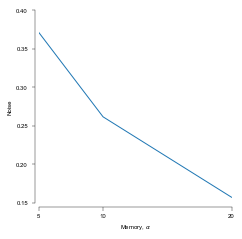

In [7]:
# Figure 2 plottting
initial_mean = 0
initial_std = 1
var_env = 4
# read data
data = pd.read_csv('data/SIfig5_tradeoff.csv.gz', compression='gzip')

# Plotting -----------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.8])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_position(('axes', -0.02))
ax1.spines['left'].set_position(('axes', -0.02))

alphas = [5, 10, 20]
stdsy = []
for alpha in alphas:
	stds = data.loc[(data['alpha'] == alpha) 
			   & (data['Initial mean'] == initial_mean) 
			   & (data['Initial std'] == initial_std)]['Std'].values
	stdsy.append(np.std(stds[-700:-1])) # using last 700 encounters, exclude the first 300
ax1.plot(alphas,stdsy)
ax1.set_xlabel(r'Memory, $\alpha$')
ax1.set_ylabel('Noise')
ax1.set_xlim([5,20])
ax1.set_xticks(alphas)
ax1.set_ylim([0.15,0.4])

plt.savefig('figs5-adaptation-tradoff.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# FigS6 FK

In [45]:
u2 = 0  # signal mean and std
sigma2 = 1  
theta = 0.01
alpha = 10
kappa = 20
c1 = (alpha-1)/(alpha-0.5) # constant in betanew = c1*beta + c2*(x-mu)**2
c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
mean_antigen = 2.5  # antigen N(4.5,1) when calculating POA
var_antigen = 1

# grid
NX = 101
NY = 101
xmax = 0.5
xmin = -0.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

m = [0]*(NX*NY)
beta = [0]*(NX*NY)
poa = [0]*(NX*NY)
for i in range(NX):
    for j in range(NY):
        m[i*NY+j] = xmin+i*dx
        beta[i*NY+j] = ymin+j*dy
        poa[i*NY+j] = POA(alpha, kappa, m[i*NY+j],
                          beta[i*NY+j], mean_antigen, var_antigen)
df = pd.DataFrame()
df['alpha'] = [alpha]*(NX*NY)
df['kappa'] = [kappa]*(NX*NY)
df['Antigen mean'] = [mean_antigen]*(NX*NY)
df['Antigen var'] = [var_antigen]*(NX*NY)
df['M'] = m
df['Beta'] = beta
df['Poa'] = poa
df.to_csv('S6poa_matrix.csv.gz', index=None, header=True, compression='gzip')
print('Fig s6 poa matrix done')

Fig s6 poa matrix done


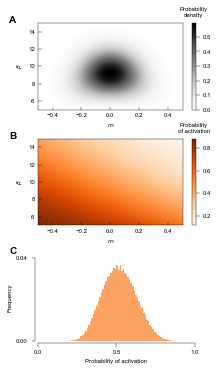

In [8]:
NX = 101
NY = 101
xmax = 0.5
xmin = -0.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

# load data
dataw = pd.read_csv('%sSFokker_planck_solution.csv.gz' %
                    (DATA_FOLDER), compression='gzip')
col = dataw.columns[-1]
w = dataw[col]
w = np.array(w).reshape((NX, NY))
data = pd.read_csv('%sS6poa_matrix.csv.gz' % (DATA_FOLDER), compression='gzip')
poa = np.array(data['Poa']).reshape((NX, NY))

# plotting ---------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
h = 0.24
s = 0.08
ax1 = fig.add_axes([0.15, 0.95 - h, 0.75, h])
ax2 = fig.add_axes([0.15, 0.95 - 2*h - s, 0.75, h])
ax3 = fig.add_axes([0.15, 0.95 - 3*h - 2*s, 0.65, h])
fig.text(
    0.03, 0.95, string.ascii_uppercase[0].upper(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - (h+s), string.ascii_uppercase[1].upper(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - 2*(h+s), string.ascii_uppercase[2].upper(), size=SUBLABEL_SIZE, weight='bold')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$m$')
ax2.set_ylabel(r'$\beta$')

ax3.set_xlabel(POA_LABEL)
ax3.set_ylabel('Frequency')
ax3.set_xlim([0, 1])
ax3.set_ylim([-0.0002, 0.042])
ax3.set_yticks([0, 0.04])
ax3.spines['left'].set_bounds(0, 0.04)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
X = xmin+dx*np.arange(NX)
Y = ymin+dy*np.arange(NY)

colorinterpolation = 50  # Set colour interpolation and colour map
pos1 = ax1.pcolormesh(X, Y, w.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Greys'))
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('Probability\ndensity', fontsize=LABEL_SIZE)
cbar1.set_ticks(np.arange(0, 0.9, step=0.1))

pos2 = ax2.pcolormesh(X, Y, poa.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Oranges'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('Probability\nof activation', fontsize=LABEL_SIZE)
cbar2.set_ticks(np.arange(0, 1, step=0.2))

poa_c = sns.color_palette('Oranges', n_colors=1)

# bins for poa histgram
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
xbin = []
y3 = []
for ibin in range(int(1.0/binstep)):
    xbin.append((ibin+0.5)*binstep)
    y3.append(0)
for ix in range(NX):
    for iy in range(NY):
        ibin = 0
        while ibin*binstep < poa[ix, iy]:
            ibin += 1
        y3[ibin] += w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
ax3.bar(xbin, height=y3plot, width=binstep, align='center', alpha=0.8, facecolor=poa_c[0])
ax3.set_xticks([0, 0.5, 1])

plt.savefig('figs6-heterogeneity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure S7 Elliott exp data

[[0.1925     0.06766667]]


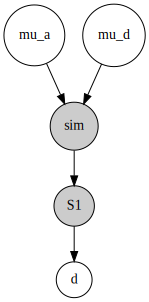

In [5]:
# ELFI simulation
def sim_experiment(mu_env, mu_a, N_nk, batch_size):
	alpha = 10
	kappa = 2*alpha
	ms=np.zeros((batch_size,N_nk))
	betas=np.ones((batch_size,N_nk))*alpha
	N_train = 300 # to ensure parameters adapt to new env
	for i in range(N_train):
		xs = np.random.normal(mu_env, 1,size=(batch_size,N_nk)) 
		# mu_env and 1 .size=betch_size, xs[i,:]~N(mu[i],si[i])
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
	N_response = 300 # last as long as the adaption time needed
	response = np.zeros((batch_size,N_response))
	for i in range(N_response):
		xs = np.random.normal(mu_env, 1,size=(batch_size,N_nk))
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
		thresholds = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
		poas = 1-norm.cdf(thresholds, loc=mu_a, scale=1)
		response[:,i] = np.mean(poas,axis=1) 
	return(response)

def simulator(mu_a, mu_d, batch_size=10, random_state=None):
	'''
	alpha is memory length
	wild type signal N(0,1), 
	MHC-I deficient signal N(mu_d, 1^2),
	aberrant signal distribution N(mu_a,1^2).
	'''
	mu_a = np.array(mu_a).reshape((-1,1))
	mu_d = np.array(mu_d).reshape((-1,1)) 
	# in wild type, trained in wild type signal and calculate response to aberrant signal
	N_nk = 100
	response_w = sim_experiment(np.array([0]).reshape((-1,1)), mu_a,N_nk, batch_size)
	w_mean = np.mean(response_w,axis=1)
	# in MHC dificient type
	response_d = sim_experiment(mu_d, mu_a, N_nk, batch_size)
	d_mean = np.mean(response_d,axis=1)
	res = np.zeros((batch_size,2))
	res[:,0] = w_mean
	res[:,1] = d_mean
	return(res)
exp_w = np.array([19.8, 22.9, 16.8, 20.5, 16.9, 18.6])/100
exp_d = np.array([4.4, 10.6, 5, 6.2, 7.2, 7.2])/100
y_exp = np.array([[np.mean(exp_w), np.mean(exp_d)]])
print(y_exp)


mu_a = elfi.Prior('gamma', 2, 0, 2)
mu_d = elfi.Prior('gamma', 2, 0, 2)

sim = elfi.Simulator(simulator, mu_a, mu_d, observed=y_exp)

def feature(x): 
	return(x)

def distance(res_sim,res_obs):
	# relative diffeerence
	# d=np.sum(((res_sim-res_obs)/res_obs)**2,axis=1)
	d=np.sum((res_sim-res_obs)**2,axis=1)
	return(d)
S1 = elfi.Summary(feature, sim)
d = elfi.Distance(distance, S1) # d btw summary and observe
elfi.draw(d) 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.00346
Sample means: mu_a: 1.49, mu_d: 0.875


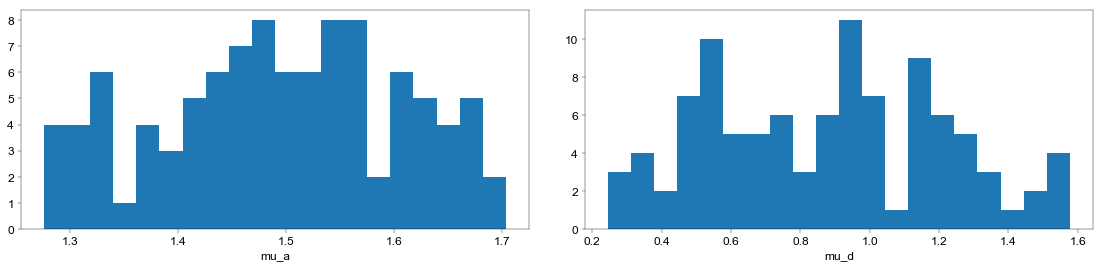

In [6]:
seed = 20170530
rej = elfi.Rejection(d,batch_size=10,seed=seed) 
result = rej.sample(100, quantile=0.01) 
result.summary()
result.plot_marginals();

In [7]:
# save samples selected
data=pd.DataFrame()
data['mu_a'] = result.samples['mu_a']
data['mu_d'] = result.samples['mu_d']
print(data.head())
data.to_csv('S7parafit.csv')

       mu_a      mu_d
0  1.494929  0.594672
1  1.501401  0.618684
2  1.498663  0.528282
3  1.429152  0.578477
4  1.435725  0.671028


In [15]:
def update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0):
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	for nstep in range(num_encounter):
		xs = np.random.normal(signal_mean, 1, size=(n_cells))  # gauss(mean,std)
		ms_new = (kappa*ms_est+xs)/(kappa+1)
		betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
		ms_est = ms_new
		beta_est = betas_new
	return(ms_est, beta_est)


# Calculate the probability of activation
def POA_s7(alpha, kappa, ms_est, beta_est, u_target, env_mean=0):
	n_updates = 150
	n_cells = len(ms_est)
	theta = 0.01
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	poa_mean = []
	for i in range(n_updates):
		thresholds = t.ppf(1-theta, 2*alpha, ms_est, np.sqrt((kappa+1)*beta_est/kappa/alpha))
		poa = 1-norm.cdf(thresholds, loc=u_target, scale=1)
		poa_mean.append(np.mean(poa))
		# update
		xs = np.random.normal(env_mean,1,size=(n_cells) )
		ms_new = (kappa*ms_est+xs)/(kappa+1)
		betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
		ms_est = ms_new
		beta_est = betas_new
	return(poa_mean)

mu_a = 1.49 
mu_d = 0.59 
# constants
alpha = 10
kappa = 2*alpha
#initial encounters
num_encounter = 50*alpha
n_cells = 1000

# blue line N(0,1)
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter) 
poa_mean_blue = POA_s7(alpha, kappa, ms_est, beta_est, mu_a)

# green line N(mu_d, 1)
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
poa_mean_green = POA_s7(alpha, kappa, ms_est, beta_est, mu_a, env_mean=mu_d)

# black line
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
poa_mean_black = POA_s7(alpha, kappa, ms_est, beta_est, mu_a)

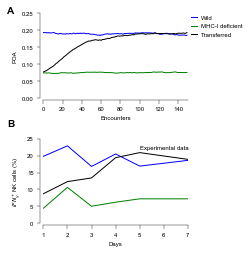

In [16]:
# plot adaptation
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.15, 0.62, 0.6, 0.35])
ax2 = fig.add_axes([0.15, 0.1, 0.6, 0.35])
ax1.text(-0.25, 1.0, string.ascii_uppercase[0].upper(),
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.text(-0.25, 1.15, string.ascii_uppercase[1].upper(),
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_position(('axes', -0.02))
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))


ax1.plot(poa_mean_blue,c='blue',label='Wild')
ax1.plot(poa_mean_green,c='green',label='MHC-I deficient')
ax1.plot(poa_mean_black,c='black',label = 'Transferred')
ax1.set_xlim([0,150])
ax1.set_ylim([0,0.25])
ax1.set_xlabel('Encounters')
ax1.set_ylabel('POA')
ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.6, 0.1, 0.5),handlelength=1, frameon=False)


x=[1,2,3,4,5,7]
exp_blue = [19.8, 22.9, 16.8, 20.5, 16.9, 18.6]
exp_black = [8.7, 12.3, 13.4, 19.4, 20.9, 18.9]
exp_green = [4.4, 10.6, 5, 6.2, 7.2, 7.2]
ax2.text(5,22,'Experimental data')
ax2.plot(x,exp_blue,c='blue',label='Wild')
ax2.plot(x,exp_green,c='green',label='MHC-I deficient')
ax2.plot(x,exp_black,c='black',label = 'Transferred')
ax2.set_xlim([1,7])
ax2.set_ylim([0,25])
ax2.set_xlabel('Days')
ax2.set_ylabel(r'$IFN_{\gamma}^{+}$ NK cells (%)')
#ax2.legend(loc='center',bbox_to_anchor=(0.85, 0.75, 0.1, 0.5),handlelength=1, frameon=False)


plt.savefig('figs7-adaption2envs.pdf', format='pdf', dpi=300)
plt.show()


## Figure S8 Srpan exp data

In [3]:

def sim_experiment(alpha,mu_R, mu_M, N_nk, batch_size):
	kappa = 2*alpha
	ms=np.zeros((batch_size,N_nk))
	betas=np.ones((batch_size,N_nk))*alpha
	N_train = 300 # to ensure parameters adapt to healthy env
	for i in range(N_train):
		xs = np.random.randn(batch_size,N_nk)
		# mu_env and sigma_env .size=betch_size, xs[i,:]~N(mu[i],si[i])
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
		thresholds = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
	# interact with RR MM
	response = np.zeros((batch_size,N_nk,4))
	# RR
	xs = np.random.normal(mu_R, 1,size=((batch_size,N_nk)))
	response[:,:,0] = xs > thresholds
	ms_new_rr = (kappa*ms+xs)/(kappa+1)
	betas_rr = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
	ms_rr = ms_new_rr
	thresholds_rr = t.ppf(0.99, 2*alpha, ms_rr, np.sqrt((kappa+1)*betas_rr/kappa/alpha))
	xs = np.random.normal(mu_R, 1,size=((batch_size,N_nk)))
	response[:,:,1] = xs > thresholds_rr
	# MM
	xs = np.random.normal(mu_M, 1,size=((batch_size,N_nk)))
	response[:,:,2] = xs > thresholds
	ms_new_MM = (kappa*ms+xs)/(kappa+1)
	betas_MM = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
	ms_MM = ms_new_MM
	thresholds_MM = t.ppf(0.99, 2*alpha, ms_MM, np.sqrt((kappa+1)*betas_MM/kappa/alpha))
	xs = np.random.normal(mu_M, 1,size=((batch_size,N_nk)))
	response[:,:,3] = xs > thresholds_MM
	# cal 00,01,10,11
	result = np.zeros((batch_size,8))
	RR00 = (response[:,:,0]==0)*(response[:,:,1]==0)
	RR10 = (response[:,:,0]==1)*(response[:,:,1]==0)
	RR01 = (response[:,:,0]==0)*(response[:,:,1]==1)
	RR11 = (response[:,:,0]==1)*(response[:,:,1]==1)
	result[:,0] = np.sum(RR00,axis=1)/N_nk
	result[:,1] = np.sum(RR10,axis=1)/N_nk 
	result[:,2] = np.sum(RR01,axis=1)/N_nk
	result[:,3] = np.sum(RR11,axis=1)/N_nk
	MM00 = (response[:,:,2]==0)*(response[:,:,3]==0)
	MM10 = (response[:,:,2]==1)*(response[:,:,3]==0)
	MM01 = (response[:,:,2]==0)*(response[:,:,3]==1)
	MM11 = (response[:,:,2]==1)*(response[:,:,3]==1)
	result[:,4] = np.sum(MM00,axis=1)/N_nk
	result[:,5] = np.sum(MM10,axis=1)/N_nk 
	result[:,6] = np.sum(MM01,axis=1)/N_nk
	result[:,7] = np.sum(MM11,axis=1)/N_nk
	return(result)

def simulator(alpha, mu_R, mu_M, batch_size=10, random_state=None):
	alpha   = np.array(alpha).reshape((-1,1))
	mu_R    = np.array(mu_R).reshape((-1,1))
	mu_M    = np.array(mu_M).reshape((-1,1))
	N_nk    = 500
	res     = sim_experiment(alpha, mu_R, mu_M, N_nk, batch_size)
	return(res)

[[0.345 0.285 0.18  0.19  0.1   0.285 0.055 0.56 ]]


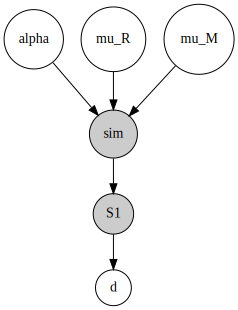

In [4]:
# observations
#exp_rr = [0.345, 0.285, 0.18, 0.19]
#exp_mm = [0.1, 0.285, 0.055, 0.56]
#exp_rm = [0.16, 0.03, 0.44, 0.37]
total = [[0.345, 0.285, 0.18, 0.19, 0.1, 0.285, 0.055, 0.56]]
y_exp = np.array(total)
print(y_exp)

# setting priot
alpha    = elfi.Prior('uniform',1,50)
mu_R     = elfi.Prior('gamma', 2, 0, 2)
mu_M     = elfi.Prior('gamma', 2, 0, 2)

sim = elfi.Simulator(simulator, alpha, mu_R, mu_M, observed=y_exp)

def feature(x): 
	return(x)

def distance(res_sim,res_obs):
	return(np.sum((res_sim-res_obs)**2,axis=1))
S1 = elfi.Summary(feature, sim)
d = elfi.Distance(distance, S1) # d btw summary and observe
elfi.draw(d) 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.0483
Sample means: alpha: 25.3, mu_M: 3.34, mu_R: 2.27


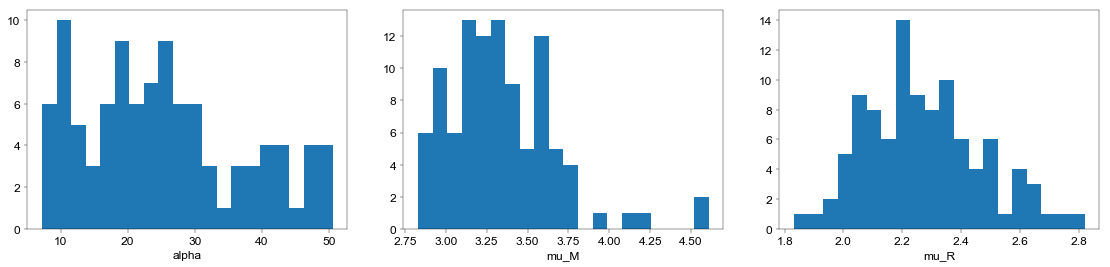

In [5]:
seed = 20210701
rej = elfi.Rejection(d,batch_size=1,seed=seed) 
result = rej.sample(100, quantile=0.01) 
#result = rej.sample(1, threshold=0.014) 
result.summary()
result.plot_marginals();

In [7]:
# save samples selected
data=pd.DataFrame()
data['alpha']   = result.samples['alpha']
data['mu_R']    = result.samples['mu_R']
data['mu_M']    = result.samples['mu_M']
print(data.head())
data.to_csv('S8parafit_rrmm.csv')

       alpha      mu_R      mu_M
0  21.448696  2.203821  3.224451
1  23.915558  2.302677  3.217432
2  16.798825  2.358604  3.398039
3  10.307480  2.414451  3.763003
4  20.278209  2.117117  3.220221


In [8]:
def killing(alpha,kappa,n_cells,ms_est,beta_est, mu_1, mu_2):
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	res = np.zeros((n_cells,2))
	xs = np.random.normal(mu_1,1,size=(n_cells))
	thresholds = t.ppf(0.99, 2*alpha, ms_est, np.sqrt((kappa+1)*beta_est/kappa/alpha))
	res[:,0] = thresholds < xs
	ms_new = (kappa*ms_est+xs)/(kappa+1)
	betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
	xs = np.random.normal(mu_2,1,size=(n_cells))
	thresholds = t.ppf(0.99, 2*alpha, ms_new, np.sqrt((kappa+1)*betas_new/kappa/alpha))
	res[:,1] = thresholds < xs
	# stat
	rr00=np.sum((res[:,0]==0)*(res[:,1]==0))/n_cells*100
	rr10=np.sum((res[:,0]==1)*(res[:,1]==0))/n_cells*100
	rr01=np.sum((res[:,0]==0)*(res[:,1]==1))/n_cells*100
	rr11=np.sum((res[:,0]==1)*(res[:,1]==1))/n_cells*100
	rr = np.array([rr00,rr10,rr01,rr11])
	return(rr)
def find_best_sample(data):
	# data
	exp_rr = np.array([0.345, 0.285, 0.18, 0.19])*100
	exp_mm = np.array([0.1, 0.285, 0.055, 0.56])*100
	exp_rm = np.array([0.16, 0.03, 0.44, 0.37])*100
	exp_mr = np.array([0.18, 0.71, 0.05, 0.06])*100
	n_sample = len(data.index)
	i_best = 0
	d_best = 400000
	for i_thfit in range(n_sample):
		alpha = data['alpha'][i_thfit]
		mu_r =  data['mu_R'][i_thfit]
		mu_m = data['mu_M'][i_thfit]
		# calculate response
		kappa = 2*alpha
		num_encounter = int(50*alpha)
		n_cells = 2000
		ms_est = np.zeros(n_cells)
		beta_est = np.ones(n_cells)*(alpha-1)
		betac1 = (alpha-1)/(alpha-0.5)
		betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
		for nstep in range(num_encounter):
			xs = np.random.randn(n_cells)  
			ms_new = (kappa*ms_est+xs)/(kappa+1)
			beta_est = betac1*beta_est + betac2*(xs-ms_est)**2
			ms_est = ms_new
		rr = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_r, mu_r)
		rm = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_r, mu_m)
		mm = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_m, mu_m)
		mr = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_m, mu_r)
		# compare with experimental data
		d_new = np.sum((exp_rr-rr)**2)+np.sum((exp_mm-mm)**2) #+np.sum((exp_rm-rm)**2)+np.sum((exp_mr-mr)**2)
		if d_new < d_best:
			i_best = i_thfit
			d_best = d_new
			sim_rr = rr
			sim_mm = mm
			sim_rm = rm
			sim_mr = mr
	return(sim_rr, sim_mm, sim_rm, sim_mr, i_best, d_best)
rr,mm,rm,mr,i_best,d_best = find_best_sample(data)
print(rr,mm,rm,mr)
print(d_best, data['alpha'][i_best],data['mu_R'][i_best],data['mu_M'][i_best])

[33.15 29.65 21.6  15.6 ] [ 5.6  26.6  12.85 54.95] [12.4  13.2  43.25 31.15] [13.4  54.95  7.45 24.2 ]
105.76000000000002 21.44869627718901 2.20382067000127 3.224450882281438


In [9]:
# constant probability of activating RR MM
exp_rr = [0.345, 0.285, 0.18, 0.19]
exp_mm = [0.1, 0.285, 0.055, 0.56]
from scipy.optimize import fmin
def likelihd(p,expdata):
	y = (expdata[0]-(1-p)**2)**2 + (expdata[1]-(1-p)*p)**2 + (expdata[2]-(1-p)*p)**2 + (expdata[3]-p**2)**2
	return(y)
initialguess = 0.5
p_R = fmin(likelihd,initialguess,args=(exp_rr,))[0]
p_M = fmin(likelihd,initialguess,args=(exp_mm,))[0]
print(p_R,p_M)
Null_rr = np.array([(1-p_R)**2, (1-p_R)*p_R, (1-p_R)*p_R, p_R**2])*100
Null_mm = np.array([(1-p_M)**2, (1-p_M)*p_M, (1-p_M)*p_M, p_M**2])*100
Null_rm = np.array([(1-p_R)*(1-p_M), p_R*(1-p_M), (1-p_R)*p_M, p_R*p_M])*100
Null_mr = np.array([(1-p_M)*(1-p_R), p_M*(1-p_R), (1-p_M)*p_R, p_M*p_R])*100

Optimization terminated successfully.
         Current function value: 0.006016
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.028466
         Iterations: 14
         Function evaluations: 28
0.41894531249999994 0.7482421875000007


In [10]:
exp_rr = np.array([0.345, 0.285, 0.18, 0.19])*100
exp_mm = np.array([0.1, 0.285, 0.055, 0.56])*100
exp_rm = np.array([0.16, 0.03, 0.44, 0.37])*100
exp_mr = np.array([0.18, 0.71, 0.05, 0.06])*100
print( np.sum((Null_rr-exp_rr)**2)+np.sum((Null_mm-exp_mm)**2)+
	  np.sum((Null_rm-exp_rm)**2)+np.sum((Null_mr-exp_mr)**2))
print( np.sum((rr-exp_rr)**2)+np.sum((mm-exp_mm)**2)+
	  np.sum((rm-exp_rm)**2)+np.sum((mr-exp_mr)**2))

1878.0284308979742
873.5500000000002


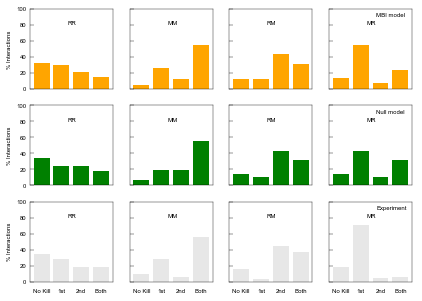

In [11]:
fig,axs = plt.subplots(3,4,sharey=True,figsize=(DOUBLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)

for i in range(3):
	for j in range(4):
		axs[i,j].tick_params(axis='y',direction="in")
		axs[i,j].tick_params(axis='x',bottom=False)
for j in range(4):
	axs[0,j].tick_params(axis='x',labelbottom=False)
	axs[1,j].tick_params(axis='x',labelbottom=False)
	axs[2,j].tick_params(axis='x',labelsize = LABEL_SIZE)
for i in range(3):
	axs[i,0].tick_params(axis='y',labelsize = LABEL_SIZE)
	# plot simulation result
xlabels = ['No Kill', '1st', '2nd', 'Both']
axs[0,0].bar(xlabels,rr, color='orange')
axs[0,1].bar(xlabels,mm, color='orange')
axs[0,2].bar(xlabels,rm, color='orange')
axs[0,3].bar(xlabels,mr, color='orange')
plt.ylim([0,100])
axs[0,0].text(1.3,80,'RR')
axs[0,1].text(1.3,80,'MM')
axs[0,2].text(1.3,80,'RM')
axs[0,3].text(1.3,80,'MR')
axs[0,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)
axs[0,3].text(1.8,90,'MBI model')
# plot null model result
axs[1,0].bar(xlabels,Null_rr, color='green')
axs[1,1].bar(xlabels,Null_mm, color='green')
axs[1,2].bar(xlabels,Null_rm, color='green')
axs[1,3].bar(xlabels,Null_mr, color='green')
plt.ylim([0,100])
axs[1,0].text(1.3,80,'RR')
axs[1,1].text(1.3,80,'MM')
axs[1,2].text(1.3,80,'RM')
axs[1,3].text(1.3,80,'MR')
axs[1,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)
axs[1,3].text(1.8,90,'Null model')

# plot experimental result
exp_rr = [0.345, 0.285, 0.18, 0.19]
exp_mm = [0.1, 0.285, 0.055, 0.56]
exp_rm = [0.16, 0.03, 0.44, 0.37]
exp_mr = [0.18, 0.71, 0.05, 0.06]
exp_rr = np.array(exp_rr)*100
exp_mm = np.array(exp_mm)*100
exp_rm = np.array(exp_rm)*100
exp_mr = np.array(exp_mr)*100
axs[2,0].bar(xlabels,exp_rr,color=(0.1, 0.1, 0.1, 0.1))
axs[2,1].bar(xlabels,exp_mm,color=(0.1, 0.1, 0.1, 0.1))
axs[2,2].bar(xlabels,exp_rm,color=(0.1, 0.1, 0.1, 0.1))
axs[2,3].bar(xlabels,exp_mr,color=(0.1, 0.1, 0.1, 0.1))
axs[2,0].text(1.3,80,'RR')
axs[2,1].text(1.3,80,'MM')
axs[2,2].text(1.3,80,'RM')
axs[2,3].text(1.3,80,'MR')
axs[2,3].text(1.8,90,'Experiment')
axs[2,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)

plt.savefig('figs8-2targetskilling.pdf',format='pdf', dpi=300)
plt.show()

## FigS9 dynamic Bayesian network coding

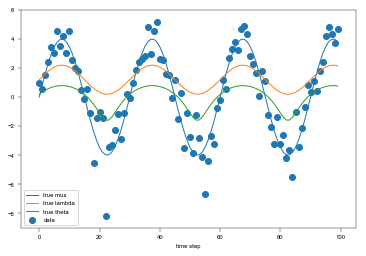

In [64]:
# true series change mean and variance 
N=100
xs=[]
mus=[]
lambdas=[]
period = 30
for i in range(N):
	mus.append(4.0*np.sin(2*np.pi*i/period))
	lambdas.append(1.0*np.sin(2*np.pi*i/period)+1.2)
	xs.append(np.random.normal(mus[-1],np.sqrt(1/lambdas[-1]))) # x~N(mu,1)
true_theta = np.log(np.array(lambdas))
plt.plot(mus,label='true mus')
plt.plot(lambdas,label='true lambda')
plt.plot(true_theta,label='true theta')
plt.scatter(np.arange(N),xs,label='data')
plt.xlabel('time step')
plt.legend()
plt.show()

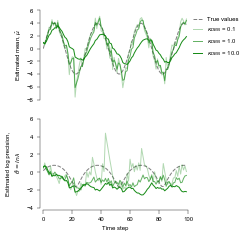

In [72]:
def cal_abcd(kappa_DBN):  # abcd stands for...
	a = [] # mu ~ N(a,np.sqrt(1/b)) 
	b = []
	c = [] # theta ~ N(c,np.sqrt(1/d))
	d = []
	a_past = 1
	b_past = 1
	c_past = 1
	d_past = 1
	for i in range(N):
		E_theta = np.exp(c_past+0.5/d_past)
		ab_con = b_past*kappa_DBN/(kappa_DBN+b_past)
		a.append((E_theta*xs[i] + ab_con*a_past)/(ab_con+E_theta))
		b.append(E_theta + ab_con)
		E_mu = (xs[i]-a_past)**2+1/b_past
		cd_con = d_past*kappa_DBN/(kappa_DBN+d_past)
		c.append((0.5+ cd_con*c_past-
				  0.5*np.exp(c_past)*(1-c_past)*E_mu)/(0.5*np.exp(c_past)*E_mu+cd_con))
		d.append(0.5*np.exp(c_past)*E_mu+cd_con)
		a_past = a[-1]
		b_past = b[-1]
		c_past = c[-1]
		d_past = d[-1]
	return(a,b,c,d)

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.17, 0.6, 0.6, 0.37])
ax2 = fig.add_axes([0.17, 0.15, 0.6, 0.37])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, labelbottom=False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))

# ax1.plot(mus,label=r'True mean, $\mu$',**DASH_STYLE)
ax1.plot(mus,label='True values',**DASH_STYLE)
ax2.plot(true_theta,**DASH_STYLE)

kappa_DBNs = [0.1,1,10]
alphas = [0.3,0.6,0.9]
for i in range(3):
	kappa_DBN = kappa_DBNs[i]
	a,b,c,d = cal_abcd(kappa_DBN)
	ax1.plot(np.arange(N), a, label='$\kappa_{DBN}$ = %.1f'%kappa_DBN, color='green', alpha=alphas[i])
	ax2.plot(np.arange(N), c, label='$\kappa_{DBN}$ = %.1f'%kappa_DBN, color='green', alpha=alphas[i])

ax1.set_xlim([0,100])
ax2.set_xlim([0,100])
ax1.set_ylim([-8,6])
ax2.set_ylim([-4,6])

ax2.set_xlabel('Time step')
ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.45, 0.1, 0.5),handlelength=1.5, frameon=False)

ax1.set_ylabel('Estimated mean, $\hat{\mu}$')
ax2.set_ylabel('Estimated log precision,\n $\hat{\\theta}=ln{\lambda}$')
plt.savefig('figs9-changeKappaDBN.pdf',format='pdf',dpi=300)
plt.show()



## FigS11 exp vs. DBN 

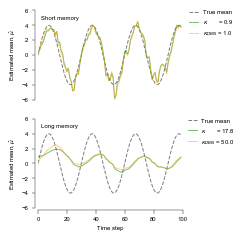

In [83]:
# calculation
# E_\theta, kappa
def cal_abcd(kappa_DBN):
	a = [] # mu ~ N(a,np.sqrt(1/b))
	b = []
	c = [] # theta ~ N(c,np.sqrt(1/d))
	d = []
	a_past = 1
	b_past = 1
	c_past = 1
	d_past = 1
	for i in range(N):
		E_theta = np.exp(c_past+0.5/d_past)
		ab_con = b_past*kappa_DBN/(kappa_DBN+b_past)
		a.append((E_theta*xs[i] + ab_con*a_past)/(ab_con+E_theta))
		b.append(E_theta + ab_con)
		E_mu = (xs[i]-a_past)**2+1/b_past
		cd_con = d_past*kappa_DBN/(kappa_DBN+d_past)
		c.append((0.5+ cd_con*c_past-
				  0.5*np.exp(c_past)*(1-c_past)*E_mu)/(0.5*np.exp(c_past)*E_mu+cd_con))
		d.append(0.5*np.exp(c_past)*E_mu+cd_con)
		a_past = a[-1]
		b_past = b[-1]
		c_past = c[-1]
		d_past = d[-1]
	return(a,b,c,d)

def cal_kappa_equiv(kappa_DBN):
	a,b,c,d = cal_abcd(kappa_DBN)
	array_b = np.array(b)
	array_c = np.array(c)
	array_d = np.array(d)
	array_Etheta = np.exp(array_c +0.5/array_d)
	inverse_kappa = array_Etheta/kappa_DBN+array_Etheta/array_b
	array_kappa = 1/inverse_kappa
	return(np.mean(array_kappa), a)
def cal_m(kappa):
	# calculate evalution of m under the signals generateed
	m_past = 1
	m=[]
	for i in range(N):
		m_new = (kappa*m_past+xs[i])/(kappa+1)
		m.append(m_new)
		m_past = m_new
	return(m)
N=100
# generate signal
xs=[]
mus=[]
lambdas=[]
period = 30
for i in range(N):
	mus.append(4.0*np.sin(2*np.pi*i/period))
	lambdas.append(1.0*np.sin(2*np.pi*i/period)+1.2)
	xs.append(np.random.normal(mus[-1],np.sqrt(1/lambdas[-1])))

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.17, 0.6, 0.6, 0.37])
ax2 = fig.add_axes([0.17, 0.15, 0.6, 0.37])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, labelbottom=False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))

ax1.plot(mus,label='True mean',**DASH_STYLE)
ax2.plot(mus,label='True mean',**DASH_STYLE)
kappa_DBN  = 1
kappa_equiv,a = cal_kappa_equiv(kappa_DBN)
m = cal_m(kappa_equiv)
ax1.plot(m, label=r'$\kappa$       = %.1f'%kappa_equiv , alpha=0.5, color = 'green')
ax1.plot(a, label=r'$\kappa_{DBN}$ = %.1f'%kappa_DBN   , alpha=0.5, color = 'orange')
	
kappa_DBN = 50
kappa_equiv,a = cal_kappa_equiv(kappa_DBN)
m = cal_m(kappa_equiv)
ax2.plot(m, label=r'$\kappa$       = %.1f'%kappa_equiv , alpha=0.5, color = 'green')
ax2.plot(a, label=r'$\kappa_{DBN}$ = %.1f'%kappa_DBN   , alpha=0.5, color = 'orange')

ax1.set_xlim([0,100])
ax1.set_ylim([-6,6])
ax2.set_xlim([0,100])
ax2.set_ylim([-6,6])

ax2.set_xlabel('Time step')
ax1.set_ylabel('Estimated mean, $\hat{\mu}$')
ax2.set_ylabel('Estimated mean, $\hat{\mu}$')
ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.6, 0.1, 0.5),handlelength=1.5, frameon=False)
ax2.legend(loc='center',bbox_to_anchor=(1.15, 0.6, 0.1, 0.5),handlelength=1.5, frameon=False)

ax1.text(15, 5, 'Short memory', ha='center', va='center', fontsize=LABEL_SIZE)
ax2.text(15, 5, 'Long memory',  ha='center', va='center', fontsize=LABEL_SIZE)

plt.savefig('figs11-dbnvsexp.pdf',dpi=300)
plt.show()
